# Iris Experiment

In [1]:
import logging
import sys
from typing import Any, Dict, List, Iterable, Tuple, Union
import warnings
warnings.filterwarnings('ignore')

import leabra7 as lb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.datasets, sklearn.metrics, sklearn.model_selection, sklearn.preprocessing
import torch
from torch import nn
from torch.optim import Adam

## LEABRA

In [2]:
LoggerType = Union[None, logging.Logger, logging.LoggerAdapter]

In [3]:
def load_data(num_feature_units: int = 10,
              logger: LoggerType = None) -> Tuple[np.ndarray, np.ndarray]:
    """Loads and preprocesses the data.
    
    Returns:
        An (X, Y) tuple containing the features and labels, respectively.
    """
    if logger is None:
        logger = logging.getLogger()
    else:
        logger.info("Loading data")
    data = sklearn.datasets.load_iris()
    
    # One-hot encode the labels
    label_binarizer = sklearn.preprocessing.LabelBinarizer()
    Y = label_binarizer.fit_transform(data.target)
    
    # Quantile transform, bin, and one-hot encode the features
    quant = sklearn.preprocessing.QuantileTransformer()
    X = quant.fit_transform(data.data)
    X = np.digitize(X, bins=np.linspace(0.0, 1.0, num=num_feature_units))
    one_hot = sklearn.preprocessing.OneHotEncoder(sparse=False)
    X = one_hot.fit_transform(X)
    
    # Randomly shuffle the data
    return sklearn.utils.shuffle(X, Y)


def build_network(input_size: int,
                  output_size: int,
                  hidden_size: int = 23,
                  logger: LoggerType = None) -> lb.Net:
    """Builds the classifier network.
    
    Args:
        input_size: The size of the input layer.
        output_size: The size of the output layer.
        hidden_size: The size of the hidden layer.
        logger: The logger to use.
    
    Returns:
        A Leabra7 network for classification.
    """
    if logger is None:
        logger = logging.getLogger()
    logger.info("Building network")
    net = lb.Net()
    
    # Layers
    layer_spec = lb.LayerSpec(gi=1.5, ff=1, fb=1,
    unit_spec=lb.UnitSpec(spike_gain=0, vm_gain=0, adapt_dt=0))
    net.new_layer("input", size=input_size, spec=layer_spec)
    net.new_layer("hidden", size=hidden_size, spec=layer_spec)
    net.new_layer("output", size=output_size, spec=layer_spec)
    logger.debug("Input layer size: %d", input_size)
    logger.debug("Hidden layer size: %d", hidden_size)
    logger.debug("Output layer size: %d", output_size)
    
    # Projections
    lrate = 0.02
    up_spec = lb.ProjnSpec(
        lrate=lrate,
        dist=lb.Uniform(0.25, 0.75),
        cos_diff_thr_l_mix=False,
        cos_diff_lrate=False)
    down_spec = lb.ProjnSpec(
        lrate=lrate,
        dist=lb.Uniform(0.25, 0.5),
        wt_scale_rel=0.3,
        cos_diff_thr_l_mix=False,
        cos_diff_lrate=False)
    net.new_projn(
        "input_to_hidden", pre="input", post="hidden", spec=up_spec)
    net.new_projn(
        "hidden_to_output", pre="hidden", post="output", spec=up_spec)
    net.new_projn(
        "output_to_hidden", pre="output", post="hidden", spec=down_spec)
    
    return net

def trial(network: lb.Net, input_pattern: Iterable[float],
          output_pattern: Iterable[float]) -> None:
    """Runs a trial.
    
    Args:
        input_pattern: The pattern to clamp to the network's input layer.
        output_pattern: The pattern to clamp to the network's output layer.
    """
    network.clamp_layer("input", input_pattern)
    network.minus_phase_cycle(num_cycles=50)
    network.clamp_layer("output", output_pattern)
    network.plus_phase_cycle(num_cycles=25)
    network.unclamp_layer("input")
    network.unclamp_layer("output")
    network.learn()
    
def epoch(network: lb.Net, input_patterns: np.ndarray,
          output_patterns: np.ndarray) -> None:
    """Runs an epoch (one pass through the whole dataset).
    
    Args:
        input_patterns: A numpy array with shape (n_samples, n_features).
        output_patterns: A numpy array with shape (n_samples, n_features).
    """
    for x, y in zip(input_patterns, output_patterns):
        trial(network, x, y)
    network.end_epoch()
    
def train(network: lb.Net,
          input_patterns: np.ndarray,
          output_patterns: np.ndarray,
          num_epochs: int = 500,
          print_freq: int = 5,
          logger: LoggerType = None) -> pd.DataFrame:
    """Trains the network.
    
    Args:
        input_patterns: A numpy array with shape (n_samples, n_features).
        output_patterns: A numpy array with shape (n_samples, n_features).
        num_epochs: The number of epochs to run. Defaults to 500.
        print_freq: Frequency of predictions. Defaults to 5.
        logger: The logger to use. If None, will use the module's default logger.
    
    Returns:
        29pd.DataFrame:
        A dataframe of metrics from the training run.
    """
    if logger is None:
        logger = logging.getLogger()
    logger.info("Begin training")
    
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
        input_patterns, output_patterns, test_size=0.2)
    
    logger.debug("Training set size: %d", X_train.shape[0])
    logger.debug("Test set size: %d", X_test.shape[0])
    
    data: Dict[str, List[float]] = {
        "epoch": [],
        "train_loss": [],
        "train_accuracy": [],
        "test_loss": [],
        "test_accuracy": []
    }
        
    for i in range(1, num_epochs + 1):
        epoch(network, X_train, Y_train)
        # Predicting is slow
        if i % print_freq == 0:
            pred_train = predict(network, X_train)
            data["epoch"].append(i)
            train_loss = sklearn.metrics.mean_squared_error(Y_train, pred_train)
            data["train_loss"].append(train_loss)
            train_acc = sklearn.metrics.accuracy_score(Y_train, pred_train, normalize=True)
            data["train_accuracy"].append(train_acc)
            pred_test = predict(network, X_test)
            test_loss = sklearn.metrics.mean_squared_error(Y_test, pred_test)
            data["test_loss"].append(test_loss)
            test_acc = sklearn.metrics.accuracy_score(Y_test, pred_test, normalize=True)
            data["test_accuracy"].append(test_acc)
            
            logger.info('[Epoch {}]  train_loss: {:.4f}  train_accuracy: {:.2f}  test_loss: {:.4f}  test_accuracy: {:.2f}'.format(
                i, train_loss, train_acc, test_loss, test_acc))
    logger.info("End training")
    return pd.DataFrame(data)

def output(network: lb.Net, pattern: Iterable[float]) -> List[float]:
    """Calculates a prediction for a single input pattern.
    
    Args:
        network: The trained network.
        pattern: The input pattern.
    
    Returns:
        np.ndarray: The output of the network after clamping the input
        pattern to the input layer and settling. The max value is set to one,
        everything else is set to zero.
    """
    network.clamp_layer("input", pattern)
    for _ in range(50):
        network.cycle()
    network.unclamp_layer("input")
    out = network.observe("output", "unit_act")["act"].values
    max_idx = np.argmax(out)
    out[:] = 0
    out[max_idx] = 1
    return list(out)

def predict(network: lb.Net, input_patterns: np.ndarray) -> np.ndarray:
    """Calculates predictions for an array of input patterns.
    
    Args:
        network: The trained network.
        input_patterns: An array of shape (n_samples, n_features)
        containing the input patterns for which to calculate predictions.

    Returns:
        np.ndarray: An array of shape (n_samples, n_features) containing the
        predictions for the input patterns.
    """
    outputs = [output(network, item)
               for item in input_patterns]
    return np.array(outputs)

In [4]:
PROJ_NAME = "iris"
np.seterr("warn")
logging.basicConfig(
    level=logging.DEBUG,
    format="%(levelname)s %(message)s",
    handlers=(
        logging.FileHandler(
            "{0}_log.txt".format(PROJ_NAME), mode="w"),
        logging.StreamHandler(sys.stdout)))

logging.info("Begin training %s", PROJ_NAME)

INFO Begin training iris


In [5]:
X, Y = load_data()
net = build_network(
    input_size=X.shape[1],
    output_size=Y.shape[1])

metrics = train(net, X, Y, num_epochs=50, print_freq=1)

# Save metrics and network for future analysis
metrics.to_csv("{0}_metrics.csv".format(PROJ_NAME), index=False)
net.save("{0}_network.pkl".format(PROJ_NAME))

INFO Building network
DEBUG Input layer size: 40
DEBUG Hidden layer size: 23
DEBUG Output layer size: 3
INFO Begin training
DEBUG Training set size: 120
DEBUG Test set size: 30
INFO [Epoch 1]  train_loss: 0.4389  train_accuracy: 0.34  test_loss: 0.4000  test_accuracy: 0.40
INFO [Epoch 2]  train_loss: 0.4000  train_accuracy: 0.40  test_loss: 0.3556  test_accuracy: 0.47
INFO [Epoch 3]  train_loss: 0.3944  train_accuracy: 0.41  test_loss: 0.2889  test_accuracy: 0.57
INFO [Epoch 4]  train_loss: 0.3444  train_accuracy: 0.48  test_loss: 0.3778  test_accuracy: 0.43
INFO [Epoch 5]  train_loss: 0.3500  train_accuracy: 0.47  test_loss: 0.3778  test_accuracy: 0.43
INFO [Epoch 6]  train_loss: 0.3000  train_accuracy: 0.55  test_loss: 0.3333  test_accuracy: 0.50
INFO [Epoch 7]  train_loss: 0.2722  train_accuracy: 0.59  test_loss: 0.3333  test_accuracy: 0.50
INFO [Epoch 8]  train_loss: 0.2167  train_accuracy: 0.68  test_loss: 0.3111  test_accuracy: 0.53
INFO [Epoch 9]  train_loss: 0.1778  train_accur

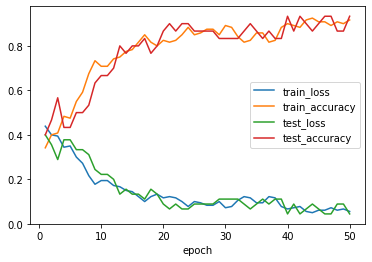

In [12]:
pd.read_csv('iris_metrics.csv').plot(x='epoch');

## Feedforward Backpropagation

In [7]:
class TorchNet(nn.Module):
    def __init__(self, input_size=40, hidden_size=23, output_size=3):
        super(TorchNet, self).__init__()
        self.linear_1 = nn.Linear(input_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(-1)
    
    def forward(self, x):
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.linear_2(x)
        x = self.softmax(x)
        return x

In [94]:
torch_net = TorchNet()
optimizer = Adam(torch_net.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()
X, Y = load_data()
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2)

nb_epochs = 50

In [95]:
data_torch: Dict[str, List[float]] = {
        "epoch": [],
        "train_loss": [],
        "train_accuracy": [],
        "test_loss": [],
        "test_accuracy": []
    }
    
for epoch in range(1, nb_epochs + 1):
    train_loss = 0
    train_acc = 0
    test_loss = 0
    test_acc = 0
    for x_train, y_train in zip(X_train, Y_train):
        label_train = torch.argmax(torch.Tensor(y_train).unsqueeze(0), axis=1)
        x_train = torch.Tensor(x_train).unsqueeze(0)
        pred_train = torch_net(x_train)
        loss_train = criterion(pred_train, label_train)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        train_loss += loss_train.item()
        train_acc += (torch.argmax(pred_train) == label_train).item()
    train_loss /= len(X_train)
    train_acc /= len(X_train)
    for x_test, y_test in zip(X_test, Y_test):
        label_test = torch.argmax(torch.Tensor(y_test).unsqueeze(0), axis=1)
        x_test = torch.Tensor(x_test).unsqueeze(0)
        with torch.no_grad():
            pred_test = torch_net(x_test)
        loss_test = criterion(pred_test, label_test)
        test_loss += loss_test.item()
        test_acc += (torch.argmax(pred_test) == label_test).item()
    test_loss /= len(X_test)
    test_acc /= len(X_test)
    data_torch["epoch"].append(epoch)
    data_torch["train_loss"].append(train_loss)
    data_torch["train_accuracy"].append(train_acc)
    data_torch["test_loss"].append(test_loss)
    data_torch["test_accuracy"].append(test_acc)
    print('[Epoch {}]  train_loss: {:.4f}  train_accuracy: {:.2f}  test_loss: {:.4f}  test_accuracy: {:.2f}'.format(
        epoch,
        train_loss,
        train_acc,
        test_loss,
        test_acc))
pd.DataFrame(data_torch).to_csv("{}_metrics.csv".format('iris_torch'), index=False)

[Epoch 1]  train_loss: 1.0917  train_accuracy: 0.47  test_loss: 1.0784  test_accuracy: 0.67
[Epoch 2]  train_loss: 1.0743  train_accuracy: 0.58  test_loss: 1.0583  test_accuracy: 0.67
[Epoch 3]  train_loss: 1.0459  train_accuracy: 0.67  test_loss: 1.0221  test_accuracy: 0.70
[Epoch 4]  train_loss: 0.9987  train_accuracy: 0.78  test_loss: 0.9638  test_accuracy: 0.83
[Epoch 5]  train_loss: 0.9307  train_accuracy: 0.85  test_loss: 0.8896  test_accuracy: 0.93
[Epoch 6]  train_loss: 0.8536  train_accuracy: 0.91  test_loss: 0.8155  test_accuracy: 0.93
[Epoch 7]  train_loss: 0.7830  train_accuracy: 0.95  test_loss: 0.7551  test_accuracy: 0.97
[Epoch 8]  train_loss: 0.7290  train_accuracy: 0.94  test_loss: 0.7118  test_accuracy: 0.93
[Epoch 9]  train_loss: 0.6922  train_accuracy: 0.93  test_loss: 0.6824  test_accuracy: 0.93
[Epoch 10]  train_loss: 0.6677  train_accuracy: 0.93  test_loss: 0.6621  test_accuracy: 0.93
[Epoch 11]  train_loss: 0.6512  train_accuracy: 0.93  test_loss: 0.6475  test_a

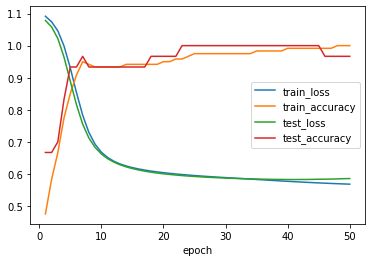

In [96]:
pd.read_csv('iris_torch_metrics.csv').plot(x='epoch');

## Report

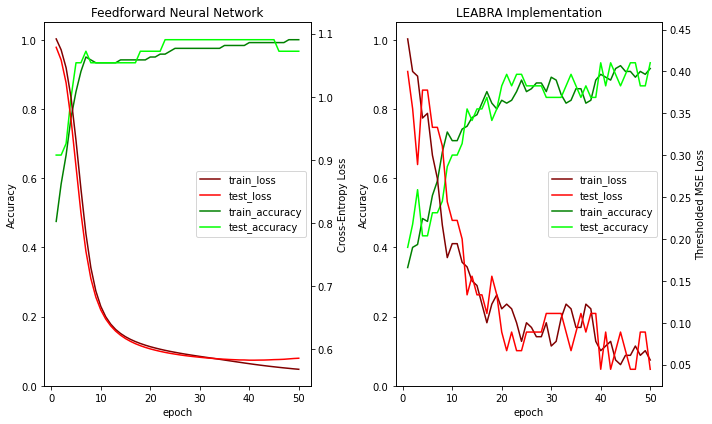

In [97]:
plt.figure(figsize=(10, 6))
ax_acc = plt.subplot(1, 2, 1)
ax_loss = ax_acc.twinx()
pd.read_csv('iris_torch_metrics.csv').plot(ax=ax_loss, y=["train_loss", "test_loss"], x="epoch", color=["maroon", "red"], legend=False);
pd.read_csv('iris_torch_metrics.csv').plot(ax=ax_acc, y=["train_accuracy", "test_accuracy"], x="epoch", color=["green", "lime"], legend=False);
ax_loss.set_title("Feedforward Neural Network")
ax_loss.set_ylabel("Cross-Entropy Loss")
ax_acc.set_ylim((0, 1.05))
ax_acc.set_ylabel("Accuracy")
handles_loss, labels_loss = ax_loss.get_legend_handles_labels()
handles_acc, labels_acc = ax_acc.get_legend_handles_labels()
plt.legend(handles_loss+handles_acc, labels_loss+labels_acc, loc="center right")

ax_acc = plt.subplot(1, 2, 2)
ax_loss = ax_acc.twinx()
pd.read_csv('iris_metrics.csv').plot(ax=ax_loss, y=["train_loss", "test_loss"], x="epoch", color=["maroon", "red"], legend=False);
pd.read_csv('iris_metrics.csv').plot(ax=ax_acc, y=["train_accuracy", "test_accuracy"], x="epoch", color=["green", "lime"], legend=False);
ax_loss.set_title("LEABRA Implementation")
ax_loss.set_ylabel("Thresholded MSE Loss")
ax_acc.set_ylim((0, 1.05))
ax_acc.set_ylabel("Accuracy")
handles_loss, labels_loss = ax_loss.get_legend_handles_labels()
handles_acc, labels_acc = ax_acc.get_legend_handles_labels()
plt.legend(handles_loss+handles_acc, labels_loss+labels_acc, loc="center right")
plt.tight_layout()
plt.savefig("iris.png", dpi=300)
plt.show();